In [22]:
from google.colab import drive # remove the cell if not using colab
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
import pandas as pd
import numpy as np
from pathlib import Path
base_path = Path('/content/drive/MyDrive/data') # change path here!

# Klasyfikacja pasażerów Titanica
Po wysłaniu raportu pozostało już tylko czekać. Dni mijały, ale w końcu telefon zadzwonił. Okazało się, że po konsultacji Twojego raportu z najbardziej doświadczonymi specjalistami w dziedzinie, zleceniodawca zdecydował się powierzyć Ci dalszą część tajemniczego zadania. Chodzi oczywiście o... **stworzenie modelu przewidującego szanse przeżycia katastrofy Titanica**.

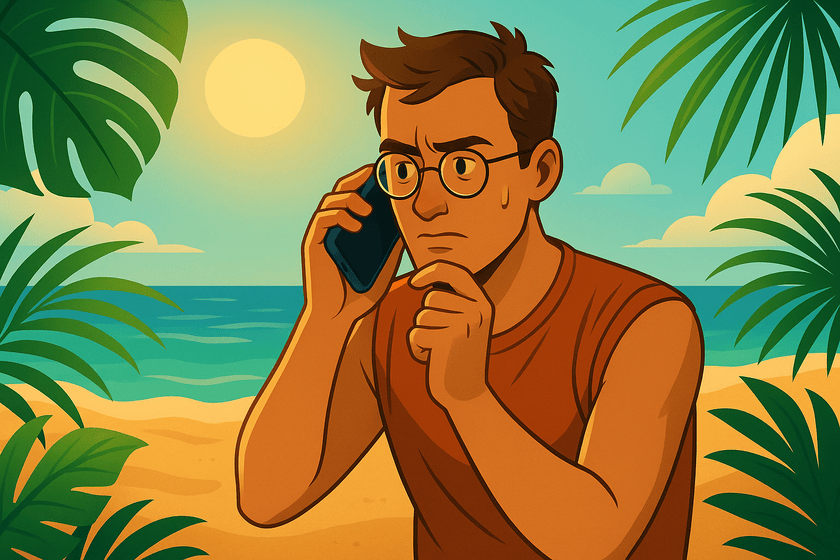

(*AI-generated image*)


#### Twoim celem będzie jest wytrenowanie modeli do klasyfikacji każdego pasażera Titanica jako ofiary (0) lub osoby, która przeżyła (1).

Poniżej znajdziesz pytania, które mogą być pomocne w zadaniu:

- Czego nauczyło Cię o badanym zbiorze danych poprzednie zadanie? Jak możesz wykorzystać wyciągnięte z niego wnioski w procesie tworzenia modelu?
- Jak przeprowadzenie standaryzacji danych może wpływać na zachowanie modelu?
- Co mój model robi i w jaki sposób?
- Jak nie przetrenować wybranego modelu?
- Jaki wynik klasyfikacji możemy uznać za *dobry*?


Wymagania:
- Wypisz obserwacje z pierwszego zadania, które pomogą Ci w tym. Co było przydatne, a co okazało się bezużyteczne?
- [Nie doprowadź](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) do ~~przecieku statku~~ wycieku danych (np. nie ucz modelu na danych testowych). Nauczone modele odpal na danych treningowych i testowych - opisz uzyskane wyniki.
- Stwórz baseline, czyli dla porównania sprawdź jak z zadaniem radzi sobie [Dummy Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html) (jeśli Twój docelowy model radzi sobie gorzej - uciekaj)
- Przeprowadź badania na dwóch wybranych modelach uczenia maszynowego (np. spośród: drzew decyzyjnych, SVM, MLP, KNN, z gwiazdką [XGBoost](https://xgboost.readthedocs.io/en/stable))
- W badaniach użyj wybranych metryk. Wybór uzasadnij.
- Dla każdego modelu wybierz co najmniej dwa hiperparametry i przeprowadź badania zależności wyników metryk od wartości hiperparametrów. Zwizualizuj wszystko ładnie, zastanów się dlaczego tak mogło być i wyciągnij i wypisz wnioski.
- Podsumuj przeprowadzone badania, wypisz wnioski.

Niezmiennie, zadbaj o czytelność kodu i nazewnictwo zmiennych. Jeśli jakiś wycinek kodu się powtarza, to wyodrębnij go do funkcji. Postaraj się zamieszczać swoje wnioski w postaci komentarza `Markdown`.

Jeśli chcesz, możesz sprawdzić (przyjmując pewne założenia), jakie byłyby Twoje szanse na Titanicu.

Uwaga! Jeśli Titanic to dla Ciebie nic i baaaaardzo chcesz to możesz w ramach tego zadania zająć się [bardziej wymagającym](https://archive.ics.uci.edu/dataset/365/polish+companies+bankruptcy+data) zbiorem.

In [24]:
titanic_df = pd.read_csv(base_path / 'titanic.csv', index_col='PassengerId')

In [25]:
titanic_df['Cabin'].str[0].unique()

array([nan, 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

Czego nauczyło Cię o badanym zbiorze danych poprzednie zadanie? Jak możesz wykorzystać wyciągnięte z niego wnioski w procesie tworzenia modelu? Wypisz obserwacje z pierwszego zadania, które pomogą Ci w tym. Co było przydatne, a co okazało się bezużyteczne?

Z poprzedniego zadania wynika:

-Nawiększy wpływ ma klasa i płeć
-Mężczyźni z rodziną mieli większe szanse na przetrwanie niż tacy bez rodziny
-Najwięcej osób przeżylo z Cherbourgu

Za zbędne dane można uznać:

*   Ticket
*   Name
*   Fare można nie uwzględniać ze względu na pełną informacje o klasie która w sobie zawiera już informacje o wysokości ceny biletu więc niosą taką samą informacje
*   Parch i Sibsp - ponieważ stworzyliśmy nowa klasę HasFamily łączącą te dwie klasy ze sobą
*   Age niesie podobną




Z ciekawości też usunęłam dane Age i Cabin, lecz to trochę zepsuło wyniki modeli niżej więc powróciłam ich ponieważ mają wpływ. Nie chciało mi się robić kopii dla sprawdzenia wszystkich opcji więc robiłam to na bieżąco

Przepisze na szybko kod dla obróbki danyvh przygotowanych do analizy

In [26]:
titanic_df = titanic_df.drop(['Name','Ticket','Fare'],axis=1)

In [27]:
titanic_df['HasFamily'] = titanic_df.apply(lambda x: 1 if x['SibSp'] > 0 or x['Parch'] > 0 else 0, axis=1)

In [28]:
titanic_df = titanic_df.drop(['Parch','SibSp'],axis=1)

In [29]:
titanic_df['Cabin'] = titanic_df['Cabin'].str[0].fillna('U')

In [30]:
titanic_df['Age']=titanic_df['Age'].fillna(titanic_df.groupby('Pclass')['Age'].transform('median'))

In [31]:
titanic_df['Embarked']=titanic_df['Embarked'].fillna('S')

In [32]:
titanic_df = titanic_df.convert_dtypes()

In [33]:
titanic_df.isna().sum()

,0
Survived,0
Pclass,0
Sex,0
Age,0
Cabin,0
Embarked,0
HasFamily,0


In [34]:
titanic_df['Sex'] = titanic_df['Sex'].map({'male': 0, 'female': 1})
titanic_df['Embarked'] = titanic_df['Embarked'].map({'C': 0, 'S': 1, 'Q': 2})
titanic_df['Cabin'] = titanic_df['Cabin'].map({
   'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'T': 8,'U': 0
})

In [35]:
titanic_df.head()

,Survived,Pclass,Sex,Age,Cabin,Embarked,HasFamily
PassengerId,,,,,,,
1,0,3,0,22.0,0,1,1
2,1,1,1,38.0,3,0,1
3,1,3,1,26.0,0,1,0
4,1,1,1,35.0,3,1,1
5,0,3,0,35.0,0,1,0


Z przygotowaniem danych koniec chyba że pozniej znajde jak to zrobic w normalny sposob zeby pobraz ich z pierwszego zadania(mam nadzieje)

Najpierw podzielimy dane dla treningu medelu na testowe i treningowe w proporcjach 0.8 / 0.2

In [36]:
from sklearn.model_selection import train_test_split

y = titanic_df['Survived'] #przewidywana
X = titanic_df.drop('Survived', axis=1) # cechy

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modele

In [37]:
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, classification_report

# DUMMY classifier

In [38]:
from sklearn.dummy import DummyClassifier
model_dummy = DummyClassifier(strategy = 'uniform')
model_dummy.fit(X_train, y_train)
y_pred = model_dummy.predict(X_test)
print(classification_report(y_test, y_pred))
confusion_matrix(y_test, y_pred)

              precision    recall  f1-score   support

         0.0       0.58      0.50      0.54       105
         1.0       0.41      0.49      0.44        74

    accuracy                           0.50       179
   macro avg       0.50      0.50      0.49       179
weighted avg       0.51      0.50      0.50       179



array([[53, 52],
       [38, 36]])

Dummy do sprawdzenia podaje wyniki na które bedziemy sie opierac jako na minimalna granice pokazującą czy model wgl działa.

# KNN

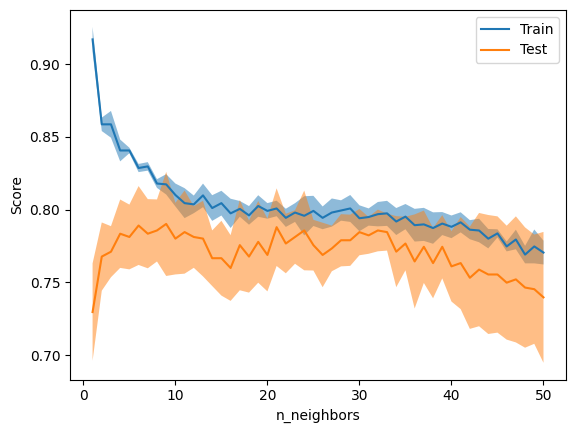

In [20]:
import matplotlib.pyplot as plt
from sklearn.model_selection import ValidationCurveDisplay
from sklearn.svm import SVC
k_range = np.arange(1, 51)
ValidationCurveDisplay.from_estimator(
    KNeighborsClassifier(metric = 'cosine'), X, y, param_name="n_neighbors", param_range=k_range,
)

Powyzej przedstawiony wykres zależności KNN od parametru ilosci sasiadow do nauczania sie. Lewa strona pokazuje przeuczenie się a prawa niedouczenie sie więc najliepiej bedzie uzyc K ze srodka przed tym jak pomaranczowa linia zaczyna spadac ( gdzies 7-15)

KNN 5 cosine

Powyżej

In [21]:
knn = KNeighborsClassifier(n_neighbors=13, metric='cosine')
knn.fit(X, y)

y_pred=knn.predict(X_test)
print(classification_report(y_test, y_pred))
confusion_matrix(y_test, y_pred)

              precision    recall  f1-score   support

         0.0       0.82      0.90      0.85       105
         1.0       0.83      0.72      0.77        74

    accuracy                           0.82       179
   macro avg       0.82      0.81      0.81       179
weighted avg       0.82      0.82      0.82       179



array([[94, 11],
       [21, 53]])

Przy uwzględnieniu zakresu ilości sąsiadów model daje dosyć wiarygodne wyniki.

# SVM

Na wykresie poniżej sprawdzam czy model jest podatny na przeuczenie sie i jaki parametr c dozwala osiągnąć najlepszy wynik

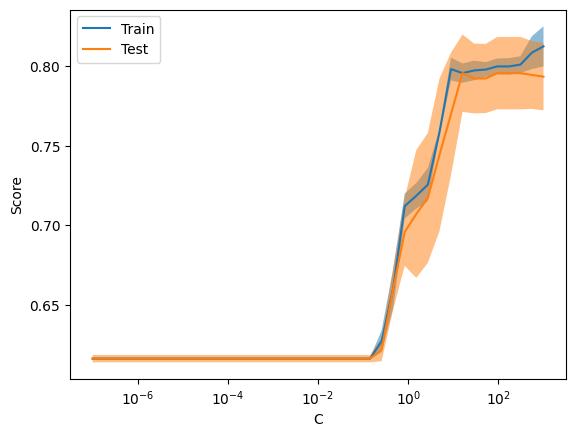

In [39]:
import matplotlib.pyplot as plt
from sklearn.model_selection import ValidationCurveDisplay
from sklearn.svm import SVC
ValidationCurveDisplay.from_estimator(
    SVC(kernel='rbf'), X, y, param_name="C", param_range=np.logspace(-7, 3, 40),
)

Najliepiej model sie sprawdza dla parametru c rownego około 10-100.

Również dla poly.Widać również ze najliepiej model sie radzi gdzieś w zakresie 9-50 ale nie wiecej

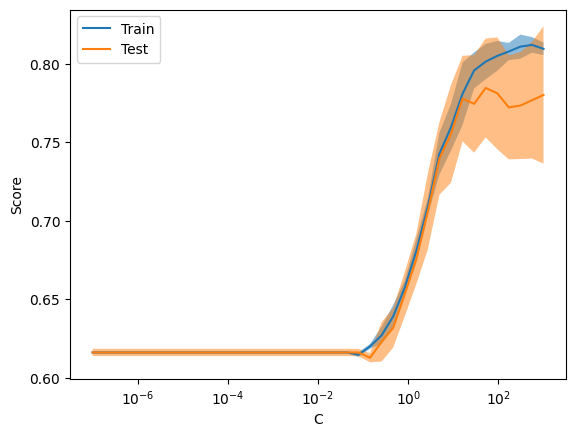

In [40]:
ValidationCurveDisplay.from_estimator(
    SVC(kernel='poly'), X, y, param_name="C", param_range=np.logspace(-7, 3, 40),
)

W modelu poly również użyc C w pewnym zakresie 10-50 zeby uniknac perzeuczania sie.

SVM linear

In [41]:
svm_lin = SVC(kernel='linear')
svm_lin.fit(X_train, y_train)
y_pred=svm_lin.predict(X_test)
print(classification_report(y_test, y_pred))
confusion_matrix(y_test, y_pred)

              precision    recall  f1-score   support

         0.0       0.80      0.84      0.82       105
         1.0       0.75      0.70      0.73        74

    accuracy                           0.78       179
   macro avg       0.78      0.77      0.77       179
weighted avg       0.78      0.78      0.78       179



array([[88, 17],
       [22, 52]])

Dla wykresów poniżej wlasnie przeprowadzalam test na przuczanie sie modelu zeby najliepiej wybrac parametry do nauczania sie

SVM rbf auto

In [42]:
svm_rbf = SVC(kernel='rbf', C = 20)
svm_rbf.fit(X_train, y_train)
y_pred=svm_rbf.predict(X_test)
print(classification_report(y_test, y_pred))
confusion_matrix(y_test, y_pred)

              precision    recall  f1-score   support

         0.0       0.81      0.84      0.82       105
         1.0       0.76      0.72      0.74        74

    accuracy                           0.79       179
   macro avg       0.78      0.78      0.78       179
weighted avg       0.79      0.79      0.79       179



array([[88, 17],
       [21, 53]])

Podałam parametr C z zakresu sprawdzonego wczesniej oraz sprawdziłam gamma auto, co spowodowało przeuczenie się modelu wiec zostało na opcji domyślnej.

SVM poly

In [43]:
svm_poly = SVC(kernel='poly', C = 30)
svm_poly.fit(X_train, y_train)
y_pred=svm_poly.predict(X_test)
print(classification_report(y_test, y_pred))
confusion_matrix(y_test, y_pred)

              precision    recall  f1-score   support

         0.0       0.71      0.87      0.78       105
         1.0       0.72      0.49      0.58        74

    accuracy                           0.71       179
   macro avg       0.71      0.68      0.68       179
weighted avg       0.71      0.71      0.70       179



array([[91, 14],
       [38, 36]])

Niestety polly zle się radzi , więc uznamy ten model za niedokladny i niepasujacy. Parametr C rowniez dopasowany do wczesniej wyliczonego zeby uniknąc przeuczanie sie modelu.

Najlipeij radzi sobie model rbf auto i daje najlepsze wyniki predykcji.

# MLP

In [44]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(random_state=1, max_iter=200, activation = 'logistic',learning_rate = 'invscaling')
mlp.fit(X_train, y_train)
y_pred=mlp.predict(X_test)
print(classification_report(y_test, y_pred))
confusion_matrix(y_test, y_pred)


              precision    recall  f1-score   support

         0.0       0.84      0.86      0.85       105
         1.0       0.79      0.77      0.78        74

    accuracy                           0.82       179
   macro avg       0.82      0.81      0.81       179
weighted avg       0.82      0.82      0.82       179



array([[90, 15],
       [17, 57]])

Wnioski:

-Najliepiej radzi sobie model MLP i KNN(dla n=13) lecz słabiej oni działają dla osób które przeżyli (oni przżyli ale on tego nie przewidział), nie wiem co można z tym zrobić

-Nie do końca wiedzialam jak zwizualizowac dane poza tym z N i C


-Staralam sie jak najoptymalnej dobrac hiperparametry

-Przez duze braki w danych ciezko jest precyzyjniej wytrenowac model